In [1]:
# Formula 1 Data Analysis
# pip install fastf1 matplotlib seaborn plotly pandas numpy sklearn xgboost

import fastf1
import fastf1.plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Enable cache
fastf1.Cache.enable_cache('f1_cache')

NotADirectoryError: Cache directory does not exist! Please check for typos or create it first.

In [ ]:
# Load Session Data
try:
    session = fastf1.get_session(2025, 'Melbourne', 'R')
    session.load()
except Exception as e:
    print("Error loading session data:", e)
    exit()
    
# Get laps data
laps = session.laps

# Data Cleaning
laps = laps[laps['LapTime'].notnull()].copy()  # Ensure a deep copy to avoid SettingWithCopyWarning
laps.loc[:, 'LapSeconds'] = laps['LapTime'].dt.total_seconds()
laps.loc[:, 'TyreLife'] = laps.groupby(['Driver', 'Compound'], observed=True).cumcount() + 1
laps.loc[:, 'DriverTeam'] = laps['Driver'] + " (" + laps['Team'] + ")"


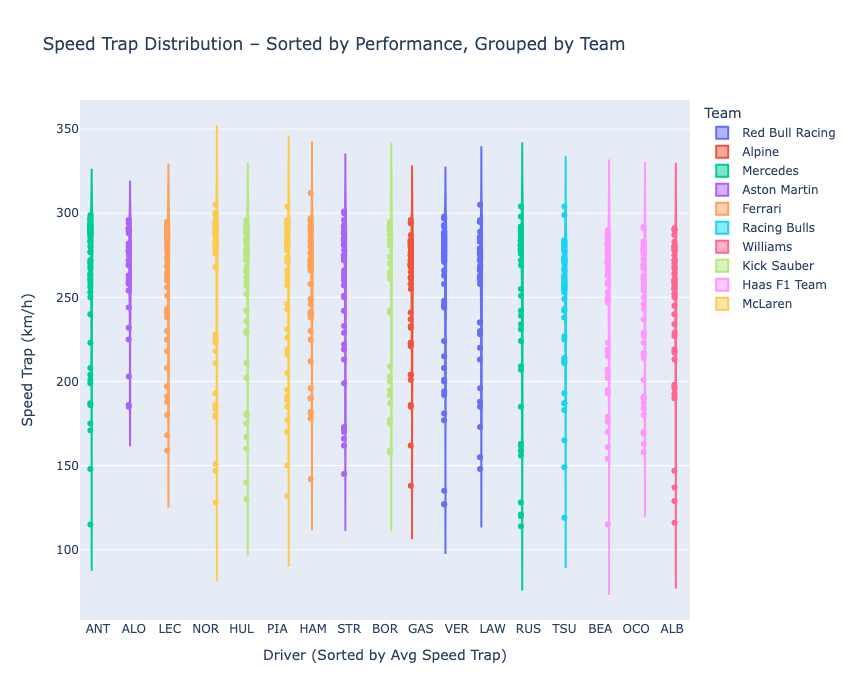

In [4]:
# Speed Trap Boxplot by Driver and Constructor

# Group by Driver to get the average speed for sorting
driver_avg_speed = laps.groupby(['Driver', 'Team'])['SpeedST'].mean().reset_index()
driver_avg_speed = driver_avg_speed.sort_values(by='SpeedST', ascending=False)

# Preserve sorting and mapping
driver_avg_speed['DriverTeam'] = driver_avg_speed['Driver'] + " (" + driver_avg_speed['Team'] + ")"
driver_order = driver_avg_speed['Driver'].tolist()
team_color_map = {team: px.colors.qualitative.Set3[i % 12] for i, team in enumerate(driver_avg_speed['Team'].unique())}

# Prepare main df
laps['DriverTeam'] = laps['Driver'] + " (" + laps['Team'] + ")"
laps['Driver'] = pd.Categorical(laps['Driver'], categories=driver_order, ordered=True)

# Create color mapping per row based on Team
laps['TeamColor'] = laps['Team'].map(team_color_map)

fig = px.violin(
    laps,
    x='Driver',
    y='SpeedST',
    color='Team',
    box=True,
    points='all',
    category_orders={'Driver': driver_order},
    hover_data={'Team': True, 'Driver': True, 'SpeedST': True},
    labels={'SpeedST': 'Speed Trap (km/h)', 'Driver': 'Driver'},
    title='Speed Trap Distribution – Sorted by Performance, Grouped by Team'
)

fig.update_layout(
    xaxis_title="Driver (Sorted by Avg Speed Trap)",
    yaxis_title="Speed Trap (km/h)",
    width=1300,
    height=700,
    violinmode='group'
)

fig.show()

In [ ]:
# Drag vs Downforce (Scatter Plot)
speed_trap = laps.groupby('Driver')['SpeedST'].mean().reset_index()
avg_speed = laps.groupby('Driver')['LapSeconds'].mean().reset_index()
race_positions = session.results[['Abbreviation', 'Position', 'Status']].rename(columns={'Abbreviation': 'Driver'})
merged_df = pd.merge(speed_trap, avg_speed, on='Driver')
merged_df = pd.merge(merged_df, race_positions, on='Driver', how='left')

# Mark drivers who did not finish (DNF)
merged_df['Race Position'] = merged_df.apply(lambda x: 'DNF' if x['Status'] != 'Finished' else str(int(x['Position'])), axis=1)

# Sort drivers by position (DNF last)
merged_df = merged_df.sort_values(by='Race Position', key=lambda x: pd.to_numeric(x, errors='coerce'))

# Append position to driver name
merged_df['Driver Label'] = merged_df['Race Position'] + " - " + merged_df['Driver']

# Plot
fig = px.scatter(
    merged_df, 
    x='LapSeconds', 
    y='SpeedST', 
    text='Driver', 
    color='Driver Label',
    labels={'LapSeconds': 'Avg Lap Time (s)', 'SpeedST': 'Speed Trap (km/h)', 'Driver Label': 'Driver (Position)'},
    title='Drag vs Downforce Analysis'
)

fig.update_traces(textposition='top center')
fig.update_layout(coloraxis_showscale=False, showlegend=False)  # Hide legend and color scale
fig.show()


In [6]:
# Tyre Degradation (Line Plot)
# Group lap data by LapNumber and Compound
avg_lap_by_compound = laps.groupby(['LapNumber', 'Compound'], observed=True)['LapSeconds'].agg(['mean', 'std']).reset_index()
avg_lap_by_compound.rename(columns={'mean': 'AvgLapTime', 'std': 'StdLapTime'}, inplace=True)

fig = px.line(
    avg_lap_by_compound,
    x='LapNumber',
    y='AvgLapTime',
    color='Compound',
    error_y='StdLapTime',
    markers=True,
    labels={'LapNumber': 'Lap Number', 'AvgLapTime': 'Lap Time (seconds)'},
    title='Tyre Degradation over Laps'
)

fig.update_traces(hovertemplate=
    'Lap %{x}<br>' +
    'Avg Time: %{y:.2f}s<br>' +
    'Compound: %{customdata[0]}',
    customdata=avg_lap_by_compound[['Compound']]
)

fig.update_layout(
    width=1000,
    height=600,
    hovermode='x unified'
)

fig.show()

In [7]:
#Race Pace Evolution with Pit Stop Strategy Overlay for Podium Finishers

# Prepare data
finish_positions = laps.groupby('Driver', observed=True)['Position'].last()
top3_finishers = finish_positions[finish_positions.between(1, 3)].sort_values()
top3_laps = laps[laps['Driver'].isin(top3_finishers.index)].copy()
top3_laps['FinishPosition'] = top3_laps['Driver'].map(finish_positions)
top3_laps['PitStopText'] = np.where(top3_laps['PitInTime'].notnull(), 'Yes', 'No')

# Calculate position changes
start_positions = laps.groupby('Driver', observed=True)['Position'].first()
top3_laps['StartPosition'] = top3_laps['Driver'].map(start_positions)

# Ensure numeric types for subtraction
top3_laps['StartPosition'] = pd.to_numeric(top3_laps['StartPosition'], errors='coerce')
top3_laps['Position'] = pd.to_numeric(top3_laps['Position'], errors='coerce')

# Now subtract safely
top3_laps['PositionChange'] = top3_laps['StartPosition'] - top3_laps['Position']
top3_laps['ChangeText'] = top3_laps['PositionChange'].apply(lambda x: f"+{x}" if x > 0 else (f"{x}" if x < 0 else "0"))

# Define color/marker for podium positions
podium_styles = {
    1: dict(color='gold', symbol='circle'),
    2: dict(color='silver', symbol='square'),
    3: dict(color='peru', symbol='diamond')
}

# Create figure
fig = go.Figure()

# Race pace lines with podium styles
for driver in top3_finishers.index:
    driver_laps = top3_laps[top3_laps['Driver'] == driver]
    pos = int(driver_laps['FinishPosition'].iloc[0])
    style = podium_styles.get(pos, dict(color='blue', symbol='circle'))

    fig.add_trace(go.Scatter(
        x=driver_laps['LapNumber'],
        y=driver_laps['LapSeconds'],
        mode='lines+markers',
        name=f"{driver} (P{pos})",
        marker=dict(color=style['color'], symbol=style['symbol']),
        line=dict(color=style['color']),
        hovertemplate=(
            "Driver: %{customdata[0]}<br>"
            "Team: %{customdata[1]}<br>"
            "Lap: %{x}<br>"
            "Lap Time: %{y:.2f}s<br>"
            "Tyre: %{customdata[2]}<br>"
            "Position: %{customdata[3]}<br>"
            "Change: %{customdata[4]}<br>"
            "Pit Stop: %{customdata[5]}"
        ),
        customdata=np.stack([
            driver_laps['Driver'],
            driver_laps['Team'],
            driver_laps['Compound'],
            driver_laps['Position'],
            driver_laps['ChangeText'],
            driver_laps['PitStopText']
        ], axis=-1)
    ))

# Pit stop markers
pit_stops = top3_laps[top3_laps['PitInTime'].notnull()]
fig.add_trace(go.Scatter(
    x=pit_stops['LapNumber'],
    y=pit_stops['LapSeconds'],
    mode='markers',
    name='Pit Stop',
    marker=dict(symbol='x', size=10, color='black'),
    hovertemplate=(
        "Pit Stop<br>"
        "Driver: %{customdata[0]}<br>"
        "Lap: %{x}<br>"
        "Lap Time: %{y:.2f}s"
    ),
    customdata=pit_stops[['Driver']]
))

# Layout adjustments
fig.update_layout(
    title='Top 3 Drivers – Race Pace Evolution with Pit Stop Strategy Overlay',
    xaxis_title='Lap Number',
    yaxis_title='Lap Time (s)',
    legend_title='Driver (Finish Position)',
    width=1200,
    height=650,
    hovermode='closest'
)

fig.show()